<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/tf2/fashion-mnist-resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST with Keras and Resnet

Adapted from 
* https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/fashion_mnist.ipynb
* https://github.com/margaretmz/deep-learning/blob/master/fashion_mnist_keras.ipynb

In [0]:
!pip install -q tf-nightly-gpu-2.0-preview

In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-dev20190819


In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
x_train.shape

(60000, 28, 28)

In [0]:
import numpy as np

# add empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [6]:
x_train.shape

(60000, 28, 28, 1)

In [0]:
# recude memory and compute time
NUMBER_OF_SAMPLES = 50000

In [0]:
x_train_samples = x_train[:NUMBER_OF_SAMPLES]

In [0]:
y_train_samples = y_train[:NUMBER_OF_SAMPLES]

In [0]:
import skimage.data
import skimage.transform

x_train_224 = np.array([skimage.transform.resize(image, (32, 32)) for image in x_train_samples])

In [11]:
x_train_224.shape

(50000, 32, 32, 1)

## Alternative: ResNet
* basic ideas
  * depth does matter
  * 8x deeper than VGG
  * possible by using shortcuts and skipping final fc layer
  * prevents vanishing gradient problem
* https://keras.io/applications/#resnet50
* https://medium.com/towards-data-science/neural-network-architectures-156e5bad51ba

http://arxiv.org/abs/1512.03385
![Deep Learning](https://raw.githubusercontent.com/DJCordhose/ai/master/docs/img/residual.png)

In [12]:
from tensorflow.keras.applications.resnet50 import ResNet50

# https://keras.io/applications/#mobilenet
# https://arxiv.org/pdf/1704.04861.pdf
from tensorflow.keras.applications.mobilenet import MobileNet

# model = ResNet50(classes=10, weights=None, input_shape=(32, 32, 1))
model = MobileNet(classes=10, weights=None, input_shape=(32, 32, 1))

model.summary()

Model: "mobilenet_1.00_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 33, 33, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 16, 16, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 16, 16, 32)  

In [13]:
%%time

BATCH_SIZE=10
EPOCHS = 10

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit(x_train_224, y_train_samples, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=1)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
50000/40000 [=====================================] - 58s 1ms/sample - loss: 0.8670 - accuracy: 0.7041 - val_loss: 0.6607 - val_accuracy: 0.7319
Epoch 2/10
50000/40000 [=====================================] - 52s 1ms/sample - loss: 0.5105 - accuracy: 0.8125 - val_loss: 0.4264 - val_accuracy: 0.8509
Epoch 3/10
50000/40000 [=====================================] - 52s 1ms/sample - loss: 0.4074 - accuracy: 0.8528 - val_loss: 0.3954 - val_accuracy: 0.8757
Epoch 4/10
50000/40000 [=====================================] - 52s 1ms/sample - loss: 0.3718 - accuracy: 0.8736 - val_loss: 0.3468 - val_accuracy: 0.8754
Epoch 5/10
50000/40000 [=====================================] - 52s 1ms/sample - loss: 0.2917 - accuracy: 0.8883 - val_loss: 0.3616 - val_accuracy: 0.8866
Epoch 6/10
50000/40000 [=====================================] - 52s 1ms/sample - loss: 0.2873 - accuracy: 0.8964 - val_loss: 0.3145 - val_accuracy: 0.8890
Epoch 7/10
500

W0819 14:20:06.290217 140445368510336 training_v2.py:146] Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 50000 batches). You may need to use the repeat() function when building your dataset.


Epoch 9/10
    0/40000 [..............................] - ETA: 0s

ValueError: ignored

NameError: ignored

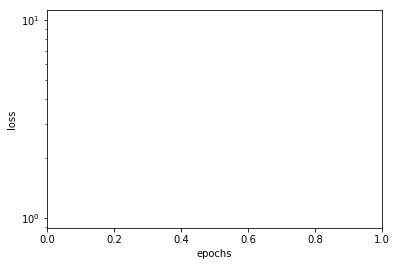

In [15]:
import matplotlib.pyplot as plt

plt.xlabel('epochs')
plt.ylabel('loss')

plt.yscale('log')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation Loss'])

In [0]:
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Accuracy', 'Validation Accuracy'])

# Checking our results (inference)

In [0]:
x_test_224 = np.array([skimage.transform.resize(image, (32, 32)) for image in x_test])

In [0]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']


def plot_predictions(images, predictions):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = plt.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    axes[x, y].text(0.5, 0.5, label + '\n%.3f' % confidence, fontsize=14)

  plt.gcf().set_size_inches(8, 8)  

plot_predictions(np.squeeze(x_test_224[:16]), 
                 model.predict(x_test_224[:16]))

In [0]:
train_loss, train_accuracy = model.evaluate(x_train_224, y_train_samples, batch_size=BATCH_SIZE)
train_accuracy

In [0]:
test_loss, test_accuracy = model.evaluate(x_test_224, y_test, batch_size=BATCH_SIZE)
test_accuracy